In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest
from matplotlib.backends.backend_pdf import PdfPages
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import umap

from Modules import plot_ax_violin
from Modules import map_to_embeddings
from Modules import exon_dist
from Modules import generate_figures
from Modules import read_data

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_lin_data():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_Pvalb-tpm.tsv'
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_Pvalb-Age-Predictions.tsv'
    df_predict = pd.read_csv(fname, **kwargs)
    kept = df_predict['CellType'].isin(('vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'))
    df_predict = df_predict.loc[kept,:].iloc[:,1:].copy()
    
    df_labels = df_labels.loc[df_labels.index.isin(df.columns)]
    df_labels.sort_values('Age', inplace=True)
    df = np.log2(1+df.loc[:,df_labels.index])
    
    return df, df_labels, df_predict

def read_olm_data():
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/Lab_OLM-tpm.tsv'
    df = pd.read_csv(fname, **kwargs)
    
    fname = 'Datasets/Lab_OLM-labels.tsv'
    df_labels = pd.read_csv(fname, **kwargs)
    df_labels = df_labels.loc[df_labels.CellType == 'SST-OLM']
    df = np.log2(1+df.loc[:,df_labels.index])
    
    fname = 'References/OLM_Age_Gender.xlsx'
    df_age = pd.read_excel(fname, index_col=0, header=1)
    df_age = df_age.loc[df_labels.index]
    df_labels['Age'] = df_age.Days
    df_labels['Gender'] = df_age.Gender
    
    return df, df_labels    

def read_cortical_data():
    df, df_labels = read_data.read_tpm_data('Lab_Cortex', log=True)
    
    return df, df_labels

def get_age_data():
    df, df_labels, df_predict = read_lin_data()
    kept = df_labels['Morph-PV-types'] == 'vBC'
    df = df.loc[:,kept].copy()
    df_labels = df_labels.loc[kept,:]
    df.columns = df_labels.Age
    
    df.sort_index(axis=1, inplace=True)
    
    return df

def get_old_cells(df_lin, df_labels, df_olm, df_olm_labels, df_cortex, df_cortex_labels):
    df_labels = df_labels.loc[df_labels.Age>20]
    df_lin = df_lin.loc[:,df_labels.index].copy()
    df_lin.columns = df_labels['Morph-PV-types']
    
    df_olm_labels = df_olm_labels.loc[df_olm_labels.Age>20]
    df_olm = df_olm.loc[:,df_olm_labels.index].copy()
    df_olm.columns = df_olm_labels.CellType
    
    df_cortex_labels = df_cortex_labels.loc[df_cortex_labels.Age>20]
    df_cortex = df_cortex.loc[:,df_cortex_labels.index].copy()
    df_cortex.columns = df_cortex_labels.CellType
    
    df_old = pd.concat((df_lin, df_olm, df_cortex), axis=1)
    
    return df_old

def get_gini_genes(cutoff=.10):
    fname = 'Gini Monte Carlo/Gene Scores.tsv'
    df_scores = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_scores = df_scores.loc[df_scores.P_Adj <= cutoff]
    df_scores.sort_values(['Up_Down', 'Cutoff_Age'], ascending=False, inplace=True)
    
    return df_scores.index.tolist()

def get_monocle_genes():
    fname = 'Datasets/Lab_Pvalb-vBC-Monocle-genes_2.tsv'
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    return genes

def plot_age_scale(ages, ax):
    age_dist = np.unique(ages)
    datalist = np.linspace(0,1,age_dist.size)[np.newaxis,:]
    pcol = ax.pcolor(datalist, vmin=0, vmax=1, cmap=mpl.cm.bwr)
    pcol.set_edgecolor('face')
    ax.axis([0,datalist.shape[1],0,1])
    ax.set_yticks([])
    
    age_labels = [age_dist.min(), 19, 27, age_dist.max()]
    inds = [.5, np.searchsorted(age_dist, 19), np.searchsorted(age_dist,27), age_dist.size-.5]
    ax.set_xticks(inds)
    ax.set_xticklabels(age_labels, fontsize=5)
    ax.tick_params(size=1, pad=1)
    ax.set_ylabel('Age (days)', fontsize=6, rotation=0, ha='right', va='center')
    
    return

def get_age_colors(ages):
    age_dist = np.unique(ages)
    colors = mpl.cm.bwr(np.linspace(0,1,age_dist.size))
    color_dict = {age:mpl.colors.rgb2hex(color) for age, color in zip(age_dist, colors)}
    
    return np.array([color_dict[age] for age in ages])

def do_genes_pca(df, ax, cax, method='gini'):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    if method.lower() == 'gini':
        df = (df>.58).astype(int)
    
    datalist = df.values.T
    #reducer = umap.UMAP(n_components=2, n_neighbors=7, min_dist=.01, random_state=42, metric='euclidean')
    plotlist = PCA(n_components=2).fit_transform(datalist)
    colors = get_age_colors(df.columns.values)
    ax.scatter(plotlist[:,0], plotlist[:,1], facecolor=colors, edgecolor='#000000', linewidth=.25, s=16)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_xlabel(r'UMAP$_1$', fontsize=7)
    ax.set_ylabel(r'UMAP$_2$', fontsize=7)
    
    plot_age_scale(df.columns.values, cax)
    
    return

def do_genes_heatmap(df, ax, cax, axbg, axrange, method='gini', age_markers=False):
    assert method.lower() in ('gini', 'monocle')
    
    if method.lower() == 'gini':
        sig_genes = get_gini_genes()
    else:
        sig_genes = get_monocle_genes()
    df = df.loc[sig_genes]
    
    df = df.loc[sig_genes,:]
    if method.lower() == 'monocle':
        Z = linkage(df.values, method='average', metric='euclidean')
        D = dendrogram(Z, no_plot=True)
        index = D['leaves']
        df = df.iloc[index,:]
        sig_genes = df.index.tolist()
    
    pcol = ax.pcolor(df.values, vmin=0, vmax=df.values.max(), cmap=mpl.cm.hot, zorder=0)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    
    inds = np.arange(len(sig_genes))+.5
    ax.set_yticks(inds)
    ax.set_yticklabels(sig_genes, fontsize=7)
    
    left, bottom, width, height = axrange
    let_left = left - .02
        
    if age_markers:
        ages = df.columns.values
        age_cutoffs = [ages.min(), 21, 25, ages.max()]
        tick_labels = ['', '', '', '']
        inds = np.searchsorted(ages, age_cutoffs)
        inds = np.array([inds[0]+.5, inds[1], inds[2], inds[3]+.5])
        ax.xaxis.tick_top()
        ax.set_xticks(inds)
        ax.set_xticklabels(tick_labels, fontsize=6)
        
        xvals = np.array([[xval, xval] for xval in inds[1:3]]).T
        yvals = np.array([[0, df.shape[0]] for xval in inds[1:3]]).T
        ax.plot(xvals, yvals, linewidth=.5, color='#AACCFF', zorder=1)
        
        ratios = (inds / ages.size)
        xvals = left + width * ratios
        xvals2 = left + width * np.array([.30*ratios[1], .8*ratios[1], 1.2*ratios[2], ratios[3]])
        axbg.text(left, bottom+height+.006, 'Age (days)', fontsize=6, ha='center', va='bottom')
        for xval, xval2, age in zip(xvals, xvals2, age_cutoffs):
            axbg.text(xval2, bottom+height+.006, age, fontsize=6, ha='center', va='bottom')
            axbg.plot([xval, xval2], [bottom+height+.002, bottom+height+.005], linewidth=.5, color='k')
        
    else:
        ax.set_xticks([])
        
    ax.tick_params(size=1, pad=1, labelsize=7)
    
    return

def manage_go_label(label, longest=30):
    labels = label.split('(GO')[0].strip().split()
    
    merged = []
    
    size = 0
    current = []
    for label in labels:
        if len(label) + size + 1 <= longest:
            current.append(label)
            size += len(label) + 1
        else:
            merged.append(' '.join(current))
            current = [label]
            size = len(label)
    
    merged.append(' '.join(current))
    
    return '\n'.join(merged)

def get_ontology_scores(method):
    base_name = 'References/GO/%s_%s.txt'
    file_types = ['Biological_Process', 'Cellular_Component', 'Molecular_Function']
    fnames = [base_name % (method, file_type) for file_type in file_types]
    
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    dfs = [pd.read_csv(fname, **kwargs) for fname in fnames]
    df = pd.concat(dfs, axis=0)
    df.sort_values('Combined Score', ascending=False, inplace=True)
    
    return df

def score_ontology(ax, method='Monocle'):
    df = get_ontology_scores(method)
    df = df.iloc[:7].iloc[::-1]
    xvals = df['Combined Score']
    yvals = np.arange(7)+.5
    ax.barh(yvals, xvals, height=.8, color='#BBBBFF', zorder=0)
    ax.set_yticks(yvals)
    labels = [manage_go_label(label) for label in df.index]
    #labels = ['GO'+label.split('(GO')[1].strip(')') for label in df.index]
    pvals = df['Adjusted P-value'].values
        
    low = xvals.min()
    high = xvals.max()
    step = (high-low) * .1
    
    for yval, pval in zip(yvals, pvals):
        ax.text(high+step/2, yval, r'$\it{p}$ = %.2f' % pval,
                ha='right', va='center', fontsize=5, zorder=1, color='#990000'
               )
    
    ax.set_xlim(low-step,high+step)
    ax.set_ylim(0,7)
    ax.set_yticklabels(labels, fontsize=5)
    ax.set_xticks([])
    ax.set_xlabel('Combined Score', fontsize=6)
    ax.set_title('Downregulated genes', fontsize=7)
    
    return
    
def plot_age_gradient(fig, axbg, method='Gini', bottom=.5):
    df = get_age_data()
    axrange = [.155, bottom, .30, .1275]
    ax = fig.add_axes(axrange)
    cax = fig.add_axes([.405, bottom-.01, .05, .005])
    do_genes_heatmap(df, ax, cax, axbg, axrange, method=method, age_markers=True)
    ax = fig.add_axes([.49, bottom, .165, .1275])
    cax = fig.add_axes([.575, bottom-.02, .08, .005])
    do_genes_pca(df, ax, cax, method=method)
    
    return

def plot_gene_fit(xvals, yvals, ax, color='blue', label=''):
    if yvals.max() == 0:
        ax.plot([xvals.min(), xvals.max()], [0,0], linewidth=1, color=color, label=label)
        norm = 0
    else:
        approx = lowess(yvals, xvals, frac=.5, is_sorted=False, return_sorted=True)
        norm = approx[-1,1]
        approx[:,1] = approx[:,1] / norm
        ax.plot(approx[:,0], approx[:,1], linewidth=1, color=color, label=label)
    
    return norm

def generate_random_color():
    numbers = np.random.randint(0,256,3)
    hexes = ['%02s' % hex(number)[2:].upper() for number in numbers]
    
    color = '#' + ''.join(hexes).replace(' ', '0')
    
    return color

def plot_hemoglobin_heatmap(df, df_labels, ax, cax, axbg, axrange):
    # do heatmap
    pcol = ax.pcolor(df.values, vmin=0, cmap=mpl.cm.hot, zorder=0)
    pcol.set_edgecolor('face')
    plt.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(size=1, labelsize=5, pad=1)
    ax.axis([0,df.shape[1],0,df.shape[0]])
    
    # annotate heatmap
    ax.set_yticks(np.arange(df.shape[0])+.5)
    ax.set_yticklabels(df.index, fontsize=7)
    ax.tick_params(labelsize=7, size=1)
    
    # add marker lines
    ages = df_labels.loc[df.columns, 'Age'].values
    age_cutoffs = [ages.min(), 21, 25, ages.max()]
    inds = np.searchsorted(ages, age_cutoffs)
    inds = np.array([inds[0]+.5, inds[1], inds[2], inds[3]+.5])
    xvals = np.array([[xval, xval] for xval in inds[1:3]]).T
    yvals = np.array([[0,df.shape[0]] for xval in inds[1:3]]).T
    ax.plot(xvals, yvals, linewidth=.5, color='#AACCFF', zorder=1)
    ax.set_xticks(inds)
    ax.set_xticklabels(['', '', '', ''])
    ax.tick_params(axis='x', labelsize=5)
    ax.xaxis.tick_top()
    
    left, bottom, width, height = axrange
    
    ratios = (inds / ages.size)
    xvals = left + width * ratios
    xvals2 = left + width * np.array([.5*ratios[1], .8*ratios[1], 1.2*ratios[2], ratios[3]])
    axbg.text(left, bottom+height+.006, 'Age (days)', fontsize=6, ha='center', va='bottom')
    for xval, xval2, age in zip(xvals, xvals2, age_cutoffs):
        axbg.text(xval2, bottom+height+.006, age, fontsize=6, ha='center', va='bottom')
        axbg.plot([xval, xval2], [bottom+height+.002, bottom+height+.005], linewidth=.5, color='k')
    
    return

def get_homoglobin_data(df_lin, df_labels):
    genes = ['Hba-a1', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Hp', 'Mb', 'Ngb', 'Cygb', 'Gh'][::-1]
    gene_colors = {gene:generate_random_color() for gene in genes}
    df_labels = df_labels.loc[df_labels['Morph-PV-types'].isin(('vBC',))]
    df_lin = df_lin.loc[genes,df_labels.index]
    df_age = df_lin.groupby(df_labels.Age, axis=1).mean()
    
    return df_lin, df_age, gene_colors

def adjust_homoglobin_axis(ax):
    ax.set_xlabel('Age (days)', fontsize=8)
    ax.set_ylabel('Expression Level\n(Normalized Log2 TPM)', fontsize=8)
    ax.tick_params(labelsize=6, size=1)
    ax.set_xlim(9,78)
    ax.set_yticks([0,0.5,1])
    return

def violin_plot_gene(data, celltypes, ax, df_marker, gene, label=True):
    if label:
        ax.set_xticks(np.arange(len(celltypes))+.5)
        ax.set_xticklabels(celltypes, rotation=45, ha='right', fontsize=6)
    else:
        ax.set_xticks([])
    
    for num, celltype in enumerate(celltypes):
        xval = num + .5
        yvals = data.loc[celltype].values
        edge, face, marker = df_marker.loc[celltype,:]
        violin_args = {'show_violin':True, 'show_scatter':False, 'alpha':1, 'precision':10}
        plot_ax_violin.plot_ax_violin(ax, yvals, xval, face, 'k', **violin_args)
    
    ax.set_xlim(0,len(celltypes))
    high = max(data.max(),1)
    ax.set_yticks([high/2])
    ax.set_yticklabels([gene], fontsize=6)
    ax.tick_params(axis='y', size=1)
    ax.set_ylim(-.1,high+.1)
    
    return

def plot_hemoglobin_data(fig, axbg, df_hemo, df_age, df_old, df_labels, gene_colors, bot=.12):
    axrange = [.155, bot, .30, .1275]
    ax = fig.add_axes(axrange)
    cax = fig.add_axes([.400, bot-.01, .055, .005])
    plot_hemoglobin_heatmap(df_hemo, df_labels, ax, cax, axbg, axrange)
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    ax = ax = fig.add_axes([.53, bot, .125, .1275])
    for gene in df_age.index:
        if gene not in ('Ngb', 'Mb', 'Hp', 'Gh', 'Cygb'):
            plot_gene_fit(df_age.columns, df_age.loc[gene], ax, color=gene_colors[gene], label=gene)
    ax.legend(fontsize=6, loc='lower right', bbox_to_anchor=(.98, .02))
    adjust_homoglobin_axis(ax)
    
    bottoms = np.linspace(bot, bot+.1275, df_age.shape[0]+1)[:-1]
    height = .1275 / df_age.shape[0]
    celltypes = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'SST-OLM', 'Cortical PV']
    for num, (gene, bottom) in enumerate(zip(df_age.index, bottoms)):
        ax = fig.add_axes([.735, bottom, .165, height])
        if num == bottoms.size-1:
            ax.set_title('Age >P21', fontsize=8)
            pass
        label = (num == 0)
        violin_plot_gene(df_old.loc[gene], celltypes, ax, df_marker, gene, label=label)
    
    return

def plot_prediction(df_predict, df_labels, ax, frac=.2):
    df_markers = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
    df_labels = df_labels.loc[df_predict.index,:]
    
    predicts = np.nanmean(df_predict, axis=1)
    ages = df_labels.Age.values
    celltypes = df_labels['Morph-PV-types'].values
    
    for celltype in set(celltypes):
        edge, face, marker = df_markers.loc[celltype]
        inds = celltypes==celltype
        
        ax.scatter(ages[inds], predicts[inds], facecolor=face, edgecolor=edge, marker=marker, s=16, linewidth=.5)
    
    ax.set_yticks([0,.5,1])
    ax.set_yticklabels(['<P21', 'Uncertain', '>P25'], fontsize=7)
    ax.set_xlabel('Age (days)', fontsize=7)
    ax.tick_params(axis='x', labelsize=6)
    
    # slightly perturb the data, as lowess handles repeating values poorly
    yvals = predicts + 2e-2*np.random.rand(predicts.size)*(1-2*predicts)
    xvals = ages + 2e-1*(np.random.rand(ages.size)-0.5)
    approx = lowess(yvals, xvals, frac=frac, is_sorted=False, return_sorted=True)
    
    ax.plot(approx[:,0], approx[:,1], linewidth=2, color='orange', zorder=1)
    
    return predicts

def plot_hemoglobin_basepairs(fig, exon_data, bottom=0.35):
    genes, gene_dfs, df_ref = exon_data
    celltypes=['hBC', 'vBC', 'hBIC', 'vBIC', 'vAAC']
    for col, gene in enumerate(genes):
        ax = fig.add_axes([.146 + .20*col, bottom, .154, .119])
        exon_dist.plot_gene_dist(ax, gene, gene_dfs, df_ref, celltypes=celltypes, height=0.119)
    
    return

In [3]:
def generate_main_figure(df_hemo, df_age, df_old, df_predict, df_labels, exon_data, gene_colors):
    fig, axes = generate_figures.generate_figure_07()
    axbg = axes['axbg']
    plot_age_gradient(fig, axbg, bottom=.76)
    plot_hemoglobin_data(fig, axbg, df_hemo, df_age, df_old, df_labels, gene_colors, bot=.58)
    
    ax = fig.add_axes([.735, .76, .165, .1275])
    inds = df_labels['Morph-PV-types']=='vBC'    
    plot_prediction(df_predict[inds], df_labels[inds], ax, frac=.25)
    
    plot_hemoglobin_basepairs(fig, exon_data, bottom=0.40)
    
    fig.savefig('Figures/Figure 7.pdf')
    plt.show()
    plt.close()
    
    return

In [4]:
df_lin, df_labels, df_predict = read_lin_data()
df_cortex, df_cortex_labels = read_cortical_data()
df_olm, df_olm_labels = read_olm_data()
df_hemo, df_age, gene_colors = get_homoglobin_data(df_lin, df_labels)
df_old = get_old_cells(df_lin, df_labels, df_olm, df_olm_labels, df_cortex, df_cortex_labels)
exon_data = exon_dist.get_data(datasets=['Lab_Pvalb'])

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


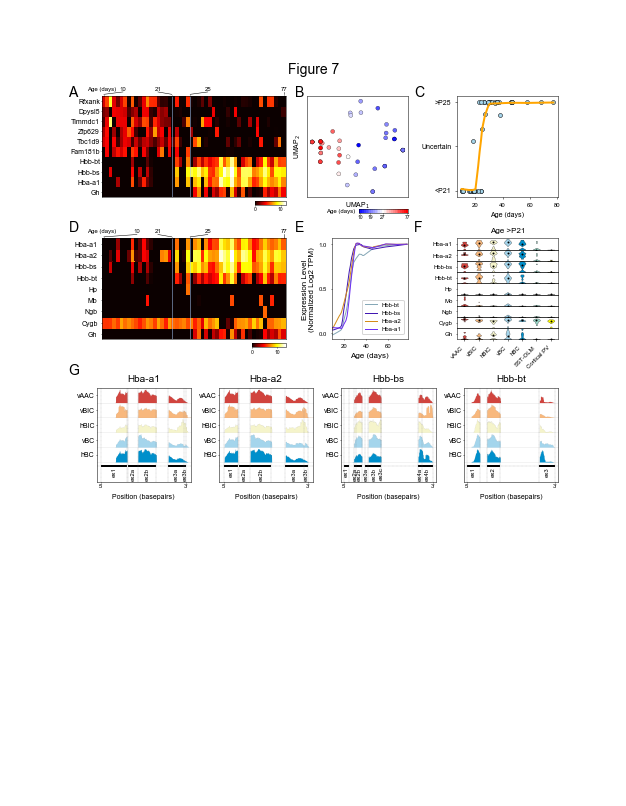

In [5]:
generate_main_figure(df_hemo, df_age, df_old, df_predict, df_labels, exon_data, gene_colors)